In [222]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import wrds
import scipy.stats as stats
import statsmodels.api as sm

db=wrds.Connection(wrds_username='sahakyan')

Loading library list...
Done


In [223]:
#---------------------------------------------
# Risk Free Rate 
#---------------------------------------------
Rf=db.raw_sql("""select  mcaldt,tmytm 
           from crsp.tfz_mth_rf            
            where kytreasnox = 2000001 
           and mcaldt>='1964-01-01'
            and mcaldt<='2023-12-31'""", date_cols=['mcaldt'])
Rf['tmytm']=Rf['tmytm']/12/100
Rf=Rf.rename(columns={ "mcaldt": "date","tmytm": "rf"})


#---------------------------------------------
# Value Weighted Index Returns
#---------------------------------------------
Rm=db.raw_sql("""select  date,vwretd from crsp.msi 
                where date>='1964-01-01' and date<='2023-12-31'
                """,date_cols=['date'])
Rm = Rm.rename(columns={'vwretd':'Rm'})

#---------------------------------------------
# Stock Returns 
#---------------------------------------------
stock_data = db.raw_sql("""
                    select a.permno, a.date, 
                      b.shrcd, b.exchcd,
                      a.ret, a.shrout, a.prc, b.siccd
                      from crsp.msf as a
                      left join crsp.msenames as b
                      on a.permno=b.permno
                      and b.namedt<=a.date
                      and a.date<=b.nameendt
                      where a.date between '01/01/1964' and '12/31/2023'
                      and b.exchcd between 1 and 2
                      and b.shrcd between 10 and 11
                      """, date_cols=['date']) 
stock_data=stock_data.drop(['shrcd','exchcd'],axis=1)
stock_data = stock_data.rename(columns={'ret':'Rn'})
stock_data['mcap'] = np.abs(stock_data['prc'])*stock_data['shrout']
stock_data['mcap_l'] = stock_data.groupby(['permno'])['mcap'].shift(1)


#---------------------------------------------
# Merge Data 
#---------------------------------------------
data = pd.merge(stock_data, Rf, on=['date'], how='left')
data = pd.merge(data, Rm, on=['date'], how='left')
data['const'] = 1
data['Rn_e'] = data['Rn']-data['rf']
data['Rm_e'] = data['Rm']-data['rf']
data.to_csv('data.csv', sep=',',index=False) # export data

# 3 Betting against Beta strategy (BaB)

In [224]:
file_name = 'data.csv'
def clean_data(file_name):
    data = pd.read_csv(file_name, sep=',', parse_dates=['date'])

    # 0. Remove nans
    data = data.dropna(subset=['mcap','mcap_l','Rn_e','Rm_e']).copy()
    
    # get rid of the day in the date
    data['date'] = data['date'].dt.to_period('M')
    data['date'] = data['date'].dt.to_timestamp()
    # Sort data by permno and date
    data = data.sort_values(by=['permno', 'date']).reset_index(drop=True)
    # save cleaned data
    data.to_csv('data.csv', sep=',',index=False) # export data

clean_data(file_name)

#### (a) Computation of time-varying Beta

In [225]:
file_name = 'data.csv'
def add_beta_to_data(file_name):
    # load data
    data = pd.read_csv(file_name, sep=',', parse_dates=['date'])

    # 2. Estimate Rolling Betas
    cov_nm = data.set_index('date').groupby('permno')[['Rn_e','Rm_e']].rolling(window = 60, min_periods=36).cov()
    beta_n = (cov_nm.iloc[0::2,1].droplevel(2)/cov_nm.iloc[1::2,1].droplevel(2))
    beta_n = beta_n.dropna().reset_index().rename(columns={'Rm_e':'beta'})

    # 3. Merge betas with data
    beta_n['date'] = beta_n['date'] + pd.DateOffset(months=1)
    data = data.merge(beta_n, on=['permno','date'], how='left')

    # get rid of nan values
    data = data.dropna(subset=['beta']).copy()

    # 4. Remove outliers
    data['beta'] = data['beta'].clip(data['beta'].quantile(0.05),data['beta'].quantile(0.95))
    # save data with the beta
    data.to_csv('data_with_beta_n.csv', sep=',',index=False)

add_beta_to_data(file_name)

#### (B) Beta Deciles

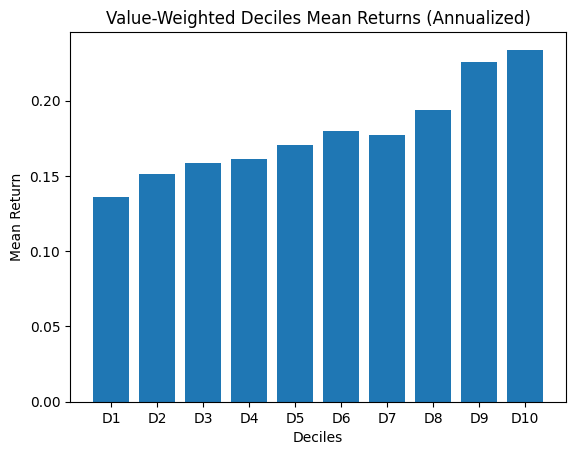

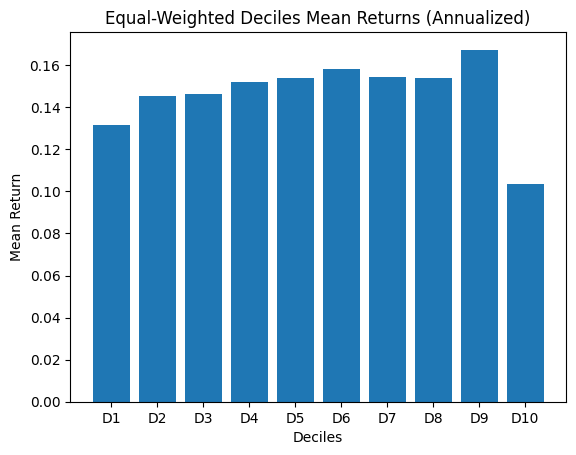

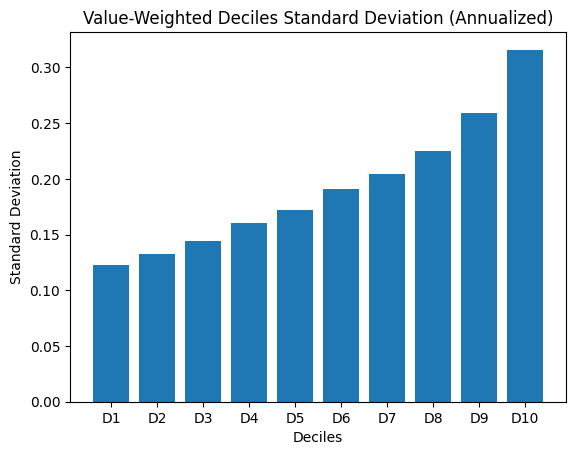

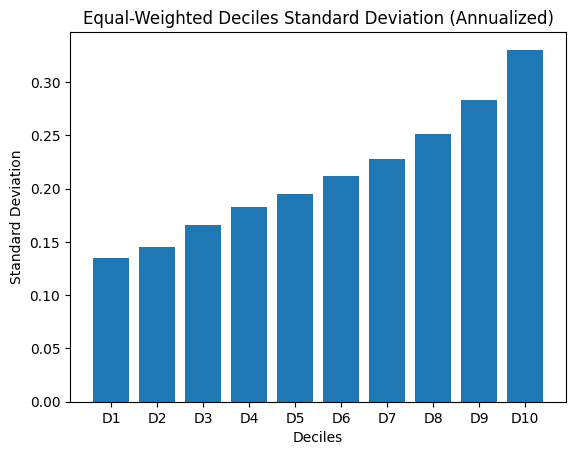

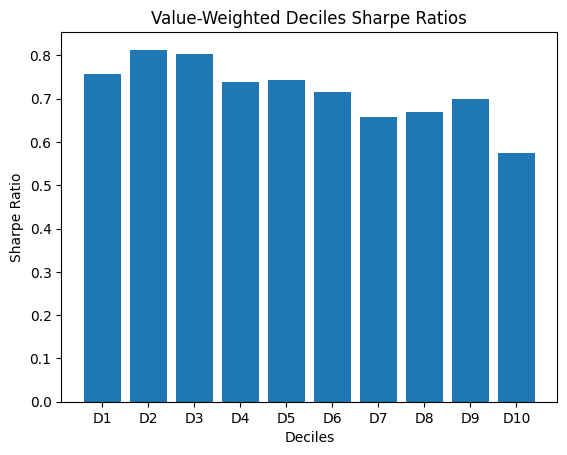

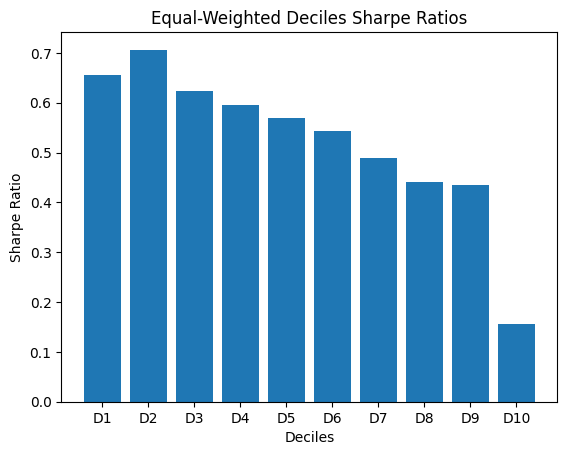

In [226]:
file_name = 'data_with_beta_n.csv'
def compute_beta_deciles(file_name, do_plot=True):
    # load data
    data = pd.read_csv(file_name, sep=',', parse_dates=['date'])

    # (b)
    # 1. Deciles
    data['beta_Q'] = data.groupby('date')['beta'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'))
    # 2. Market Weights within deciles
    data['vw_Q'] = data['mcap_l'] / data.groupby(['date', 'beta_Q'])['mcap_l'].transform('sum')

    # 3. VW Portfolios
    data['beta_ret_vw'] = data['vw_Q'] * data['Rn']
    ret_vw = data.groupby(['date', 'beta_Q'])['beta_ret_vw'].sum().reset_index()
    vw_ret_mean = ret_vw.groupby('beta_Q')['beta_ret_vw'].mean()

    # 4. Equal-Weighted portfolios
    ret_ew = data.groupby(['date', 'beta_Q'])['Rn'].mean().reset_index()
    ew_ret_mean = ret_ew.groupby('beta_Q')['Rn'].mean()

    # Calculate standard deviations
    vw_ret_std = ret_vw.groupby('beta_Q')['beta_ret_vw'].std()
    ew_ret_std = ret_ew.groupby('beta_Q')['Rn'].std()

    # Compute the Sharpe Ratios for each decile

    # compute the risk-free rate
    rf = data.groupby(['date', 'beta_Q'])['rf'].mean().reset_index()

    # compute the excess returns
    ret_vw['excess'] = ret_vw['beta_ret_vw'] - rf['rf']
    ret_ew['excess'] = ret_ew['Rn'] - rf['rf']

    # compute the Sharpe Ratios
    vw_sharpe = ret_vw.groupby('beta_Q')['excess'].mean() / ret_vw.groupby('beta_Q')['beta_ret_vw'].std()
    ew_sharpe = ret_ew.groupby('beta_Q')['excess'].mean() / ret_ew.groupby('beta_Q')['Rn'].std()

    # 5. Plot Histograms
    deciles = ['D' + str(x) for x in np.arange(1, 11)]

    directory = 'Plots/Part3'
    if do_plot:

        #save plots
        # Plot VW mean returns
        plt.bar(deciles, vw_ret_mean * 12)
        plt.title('Value-Weighted Deciles Mean Returns (Annualized)')
        plt.xlabel('Deciles')
        plt.ylabel('Mean Return')
        plt.savefig(directory + '/P3vw_ret_mean.png')
        plt.show()

        # Plot EW mean returns
        plt.bar(deciles, ew_ret_mean * 12)
        plt.title('Equal-Weighted Deciles Mean Returns (Annualized)')
        plt.xlabel('Deciles')
        plt.ylabel('Mean Return')
        plt.savefig(directory + '/P3ew_ret_mean.png')
        plt.show()

        # Plot VW standard deviations
        plt.bar(deciles, vw_ret_std * np.sqrt(12))
        plt.title('Value-Weighted Deciles Standard Deviation (Annualized)')
        plt.xlabel('Deciles')
        plt.ylabel('Standard Deviation')
        plt.savefig(directory + '/P3vw_ret_std.png')
        plt.show()

        # Plot EW standard deviations
        plt.bar(deciles, ew_ret_std * np.sqrt(12))
        plt.title('Equal-Weighted Deciles Standard Deviation (Annualized)')
        plt.xlabel('Deciles')
        plt.ylabel('Standard Deviation')
        plt.savefig(directory + '/P3ew_ret_std.png')
        plt.show()

        # Plot VW Sharpe Ratios
        plt.bar(deciles, vw_sharpe* np.sqrt(12))
        plt.title('Value-Weighted Deciles Sharpe Ratios')
        plt.xlabel('Deciles')
        plt.ylabel('Sharpe Ratio')
        plt.savefig(directory + '/P3vw_sharpe.png')
        plt.show()

        # Plot EW Sharpe Ratios
        plt.bar(deciles, ew_sharpe* np.sqrt(12))
        plt.title('Equal-Weighted Deciles Sharpe Ratios')
        plt.xlabel('Deciles')
        plt.ylabel('Sharpe Ratio')
        plt.savefig(directory + '/P3ew_sharpe.png')
        plt.show()

compute_beta_deciles(file_name)

#### (c/d) Construct BAB factor

In [227]:
file_name = 'data_with_beta_n.csv'
def construct_BAB_factor(file_name) :
    # load data
    data = pd.read_csv(file_name, sep=',', parse_dates=['date'])
    
    # Weights
    data['z'] = data.groupby('date')['beta'].transform(lambda x: x.rank())
    data['z_'] = data['z']-data.groupby('date')['z'].transform('mean')
    data['k'] = np.abs(data['z_'])
    data['k'] = 2/data.groupby('date')['k'].transform('sum')
    data['w_H'] = data['k'] * data['z_'] * (data['z_']>0) 
    data['w_L'] = -data['k'] * data['z_'] * (data['z_']<0)

    # Weighted returns and beta
    data['beta_H'] = data['w_H'] * data['beta']
    data['beta_L'] = data['w_L'] * data['beta']
    data['R_H_e'] = data['w_H'] * data['Rn_e']
    data['R_L_e'] = data['w_L'] * data['Rn_e']

    # Sum up the weighted returns and betas but not the rf
    BAB = data.groupby('date')[['R_H_e','R_L_e','beta_H','beta_L']].sum().reset_index()
    BAB['rf'] = data.groupby('date')['rf'].mean().reset_index()['rf']
    # unlevered returns
    BAB['BAB2'] = (BAB['R_L_e']/BAB['beta_L']) - ( BAB['R_H_e']/BAB['beta_H'] )

    # Merge Market and Risk free Rate
    tmp = pd.merge(BAB,data[['date','Rm_e']].drop_duplicates(), on=['date'], how='left')
    tmp['alpha'] = 1

    # Alpha and Beta
    tmp = tmp.dropna()
    OLS_Reg = sm.OLS(tmp['BAB2'], tmp[['alpha','Rm_e']]).fit()

    # Report the mean,standard deviation, and sharpe ratio and CAPM alpha of the BAB factor
    print('Mean:', tmp['BAB2'].mean()*12)
    print('Standard Deviation:', tmp['BAB2'].std()*np.sqrt(12))
    # Annualize the Sharpe ratio and CAPM alpha
    print('Sharpe ratio:', tmp['BAB2'].mean()/tmp['BAB2'].std()*np.sqrt(12))
    print('Monthly CAPM Alpha:', OLS_Reg.params['alpha']*12)
    strat = BAB[['date','rf','BAB2']]
    strat.to_csv('strat.csv', sep=',',index=False) # export data

construct_BAB_factor(file_name)

Mean: 0.11871851999333075
Standard Deviation: 0.1407032084058787
Sharpe ratio: 0.8437513354412647
Monthly CAPM Alpha: 0.08332204263071682


# 4 Momentum Strategy (Mom)

#### (a) Computating mom return

In [228]:
file_name = 'data.csv'
def computing_mom_return(file_name):
    # load data
    data = pd.read_csv(file_name, sep=',', parse_dates=['date'])

    data['LN_Cret12'] = data.groupby('permno').apply(lambda x: np.log(x.Rn+1).rolling(11, min_periods = 11, closed='left').sum()).values

    # shift the LN_Cret12 column by 1
    data['LN_Cret12'] = data.groupby('permno')['LN_Cret12'].shift(1)
    data.dropna(subset=['LN_Cret12'], inplace=True)

    q = 10
    data['Momentum'] = data.groupby('date')['LN_Cret12'].transform(lambda x: pd.qcut(x,q,labels=False, duplicates='drop'))
    # save data with the beta
    data.to_csv('data_with_momentum.csv', sep=',',index=False)

computing_mom_return(file_name)
    

C:\Users\edoul\AppData\Local\Temp\ipykernel_16716\1895451227.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data['LN_Cret12'] = data.groupby('permno').apply(lambda x: np.log(x.Rn+1).rolling(11, min_periods = 11, closed='left').sum()).values


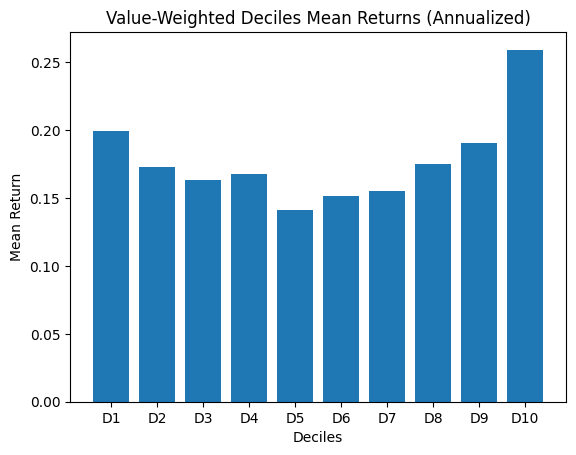

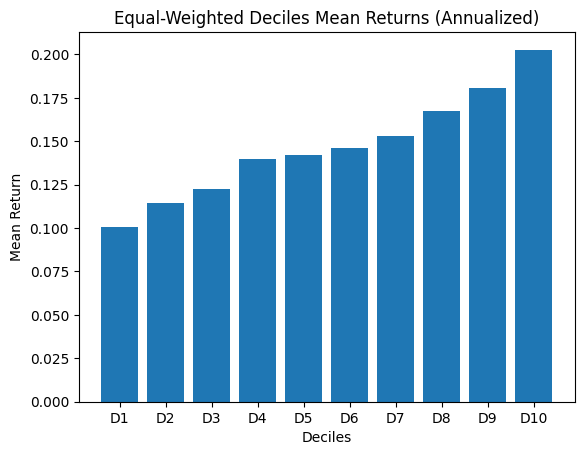

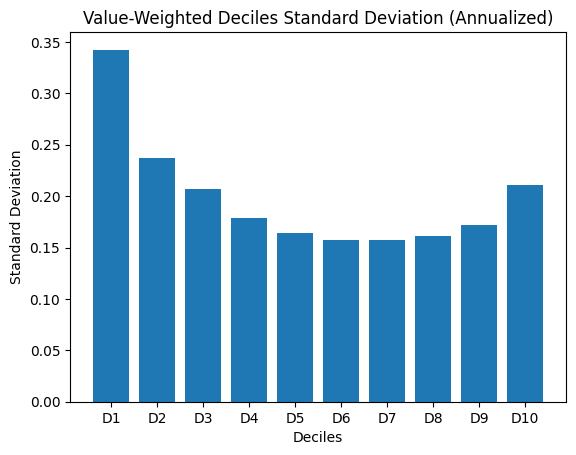

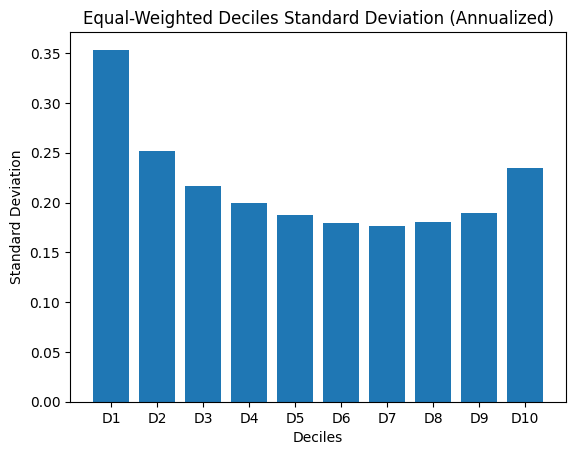

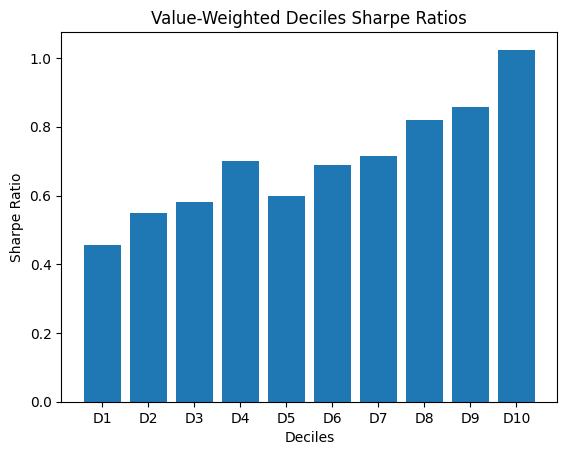

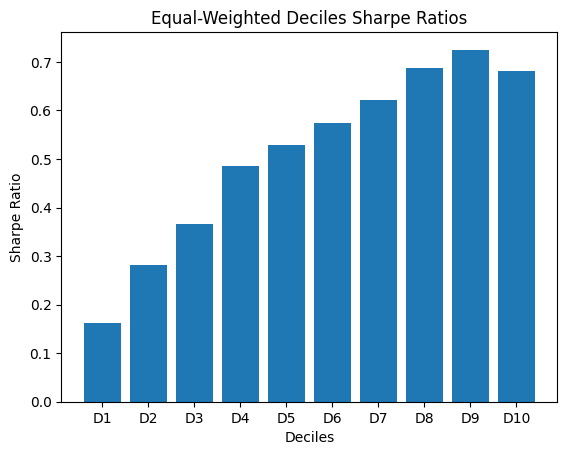

In [229]:
file_name = 'data_with_momentum.csv'
def compute_mom_deciles(file_name, do_plot=True):
    # load data
    data = pd.read_csv(file_name, sep=',', parse_dates=['date'])

    # 2. Market Weights within deciles
    data['vw_Q'] = data['mcap_l']/data.groupby(['date','Momentum'])['mcap_l'].transform('sum')

    # 3. VW Portfolios
    data['MOM_ret_vw'] = data['vw_Q']*data['Rn']
    ret_vw = data.groupby(['date','Momentum'])['MOM_ret_vw'].sum().reset_index()
    vw_ret_mean = ret_vw.groupby('Momentum')['MOM_ret_vw'].mean()

    # 4. Equal-Weighted portfolios
    ret_ew = data.groupby(['date','Momentum'])['Rn'].mean().reset_index()
    ew_ret_mean = ret_ew.groupby('Momentum')['Rn'].mean()
    # Calculate standard deviations
    vw_ret_std = ret_vw.groupby('Momentum')['MOM_ret_vw'].std()
    ew_ret_std = ret_ew.groupby('Momentum')['Rn'].std()

    # Calculate Sharpe Ratios

    # compute the risk-free rate
    rf = data.groupby(['date', 'Momentum'])['rf'].mean().reset_index()

    # compute the excess returns
    ret_vw['excess'] = ret_vw['MOM_ret_vw'] - rf['rf']
    ret_ew['excess'] = ret_ew['Rn'] - rf['rf']

    # compute the Sharpe Ratios
    vw_sharpe_ratio = ret_vw.groupby('Momentum')['excess'].mean() / vw_ret_std
    ew_sharpe_ratio = ret_ew.groupby('Momentum')['excess'].mean() / ew_ret_std

    # save data with the mom
    data.to_csv('data_with_momentum2.csv', sep=',',index=False)

    if do_plot:

        # 5. Plot Histograms
        deciles = ['D' + str(x) for x in np.arange(1, 11)]

        directory = 'Plots/Part4/'
        #save plots
        # Plot VW mean returns
        plt.bar(deciles, vw_ret_mean * 12)
        plt.title('Value-Weighted Deciles Mean Returns (Annualized)')
        plt.xlabel('Deciles')
        plt.ylabel('Mean Return')
        plt.savefig(directory + 'P4vw_ret_mean.png')
        plt.show()

        # Plot EW mean returns
        plt.bar(deciles, ew_ret_mean * 12)
        plt.title('Equal-Weighted Deciles Mean Returns (Annualized)')
        plt.xlabel('Deciles')
        plt.ylabel('Mean Return')
        plt.savefig(directory + 'P4ew_ret_mean.png')
        plt.show()

        # Plot VW standard deviations
        plt.bar(deciles, vw_ret_std * np.sqrt(12))
        plt.title('Value-Weighted Deciles Standard Deviation (Annualized)')
        plt.xlabel('Deciles')
        plt.ylabel('Standard Deviation')
        plt.savefig(directory + 'P4vw_ret_std.png')
        plt.show()

        # Plot EW standard deviations
        plt.bar(deciles, ew_ret_std * np.sqrt(12))
        plt.title('Equal-Weighted Deciles Standard Deviation (Annualized)')
        plt.xlabel('Deciles')
        plt.ylabel('Standard Deviation')
        plt.savefig(directory + 'P4ew_ret_std.png')
        plt.show()

        # Plot VW Sharpe ratios
        plt.bar(deciles, vw_sharpe_ratio * np.sqrt(12))
        plt.title('Value-Weighted Deciles Sharpe Ratios')
        plt.xlabel('Deciles')
        plt.ylabel('Sharpe Ratio')
        plt.savefig(directory + 'P4vw_sharpe_ratio.png')
        plt.show()

        # Plot EW Sharpe ratios
        plt.bar(deciles, ew_sharpe_ratio * np.sqrt(12))
        plt.title('Equal-Weighted Deciles Sharpe Ratios')
        plt.xlabel('Deciles')
        plt.ylabel('Sharpe Ratio')
        plt.savefig(directory + 'P4ew_sharpe_ratio.png')
        plt.show()

compute_mom_deciles(file_name)

### Factor creation

#### Equal-Weighted Long-Short Factor Strategy

In [230]:
file_name = 'data_with_momentum2.csv'
def mom_equal_weigthed_factor(file_name):
    # load data
    data = pd.read_csv(file_name, sep=',', parse_dates=['date'])
    # 1. Compute the long and short legs of the strategy
    ew_long_leg = data[data['Momentum'] >= 7].groupby('date')['Rn'].mean().reset_index()
    ew_short_leg = data[data['Momentum'] < 3].groupby('date')['Rn'].mean().reset_index()

    # 2. Compute the excess returns
    rf = data.groupby(['date', 'Momentum'])['rf'].mean().reset_index()

    ew_long_leg['excess'] = ew_long_leg['Rn'] - rf['rf']
    ew_short_leg['excess'] = ew_short_leg['Rn'] - rf['rf']

    # 3. Compute the mean, excess mean, standard deviation, and Sharpe ratios
    long_mean = ew_long_leg['Rn'].mean() * 12
    short_mean = ew_short_leg['Rn'].mean() * 12

    long_mean_e = ew_long_leg['excess'].mean() * 12
    short_mean_e = ew_short_leg['excess'].mean() * 12

    long_std = ew_long_leg['Rn'].std() * np.sqrt(12)
    short_std = ew_short_leg['Rn'].std() * np.sqrt(12)

    long_sharpe_ratio = long_mean_e / long_std
    short_sharpe_ratio = short_mean_e / short_std

    # Long minus short factor strategy
    factor = ew_long_leg.set_index("date") - ew_short_leg.set_index("date")
    factor = factor.reset_index()
    factor['excess'] = factor['Rn'] - rf['rf']

    factor_mean = factor['Rn'].mean() * 12
    factor_mean_e = factor['excess'].mean() * 12
    factor_std = factor['Rn'].std() * np.sqrt(12)
    factor_sharpe_ratio = factor_mean_e / factor_std

    # 4. Print the results
    print('Long Leg Mean Return:', long_mean)
    print('Short Leg Mean Return:', short_mean)
    print('Long Leg Standard Deviation:', long_std)
    print('Short Leg Standard Deviation:', short_std)
    print('Long Leg Sharpe Ratio:', long_sharpe_ratio)
    print('Short Leg Sharpe Ratio:', short_sharpe_ratio)
    print('Factor Mean Return:', factor_mean)
    print('Factor Standard Deviation:', factor_std)
    print('Factor Sharpe Ratio:', factor_sharpe_ratio)

    # Test if the factor strategy has an average return that is statistically significantly different from zero

    # 1. Compute the t-statistic
    t_stat = factor_mean / (factor_std / np.sqrt(len(factor)))

    # 2. Compute the p-value
    p_value = 1 - stats.norm.cdf(t_stat)

    # 3. Print the results
    print('T-Statistic:', t_stat)
    print('P-Value:', p_value)

    # 4. Check if the p-value is less than 0.05
    if p_value < 0.05:
        print('The factor strategy has an average return that is statistically significantly different from zero.')
    else:
        print('The factor strategy does not have an average return that is statistically significantly different from zero.')


mom_equal_weigthed_factor(file_name)

Long Leg Mean Return: 0.18354951924474774
Short Leg Mean Return: 0.11242025426333571
Long Leg Standard Deviation: 0.19784640322469477
Short Leg Standard Deviation: 0.26707597629175056
Long Leg Sharpe Ratio: 0.6761224711619408
Short Leg Sharpe Ratio: 0.23453675971568522
Factor Mean Return: 0.07112926498141205
Factor Standard Deviation: 0.16584701499416216
Factor Sharpe Ratio: 0.1287219115532357
T-Statistic: 11.403820389909137
P-Value: 0.0
The factor strategy has an average return that is statistically significantly different from zero.


#### Value-Weighted Long-Short Factor Strategy

In [231]:
file_name = 'data_with_momentum2.csv'
strat_file = 'strat.csv'
def mom_value_weigthed_factor(file_name, strat_file):
    # load data
    data = pd.read_csv(file_name, sep=',', parse_dates=['date'])
    #1. Compute the long and short legs of the strategy
    vw_long_leg = data[data['Momentum'] >= 7].groupby('date')['MOM_ret_vw'].sum().reset_index()
    vw_short_leg = data[data['Momentum'] < 3].groupby('date')['MOM_ret_vw'].sum().reset_index()

    # 2. Compute the excess returns
    rf = data.groupby(['date', 'Momentum'])['rf'].mean().reset_index()

    vw_long_leg['excess'] = vw_long_leg['MOM_ret_vw'] - rf['rf']
    vw_short_leg['excess'] = vw_short_leg['MOM_ret_vw'] - rf['rf']

    # 3. Compute the mean, excess mean, standard deviation, and Sharpe ratios
    long_mean = vw_long_leg['MOM_ret_vw'].mean() * 12
    short_mean = vw_short_leg['MOM_ret_vw'].mean() * 12

    long_mean_e = vw_long_leg['excess'].mean() * 12
    short_mean_e = vw_short_leg['excess'].mean() * 12

    long_std = vw_long_leg['MOM_ret_vw'].std() * np.sqrt(12)
    short_std = vw_short_leg['MOM_ret_vw'].std() * np.sqrt(12)

    long_sharpe_ratio = long_mean_e / long_std
    short_sharpe_ratio = short_mean_e / short_std

    # Long minus short factor strategy
    factor = vw_long_leg.set_index("date") - vw_short_leg.set_index("date")
    factor = factor.reset_index()
    factor['excess'] = factor['MOM_ret_vw'] - rf['rf']

    factor_mean = factor['MOM_ret_vw'].mean() * 12
    factor_mean_e = factor['excess'].mean() * 12
    factor_std = factor['MOM_ret_vw'].std() * np.sqrt(12)
    factor_sharpe_ratio = factor_mean_e / factor_std

    # 4. Print the results
    print('Long Leg Mean Return:', long_mean)
    print('Short Leg Mean Return:', short_mean)
    print('Long Leg Standard Deviation:', long_std)
    print('Short Leg Standard Deviation:', short_std)
    print('Long Leg Sharpe Ratio:', long_sharpe_ratio)
    print('Short Leg Sharpe Ratio:', short_sharpe_ratio)
    print('Factor Mean Return:', factor_mean)
    print('Factor Standard Deviation:', factor_std)
    print('Factor Sharpe Ratio:', factor_sharpe_ratio)

    # Test if the factor strategy has an average return that is statistically significantly different from zero

    # 1. Compute the t-statistic
    t_stat = factor_mean / (factor_std / np.sqrt(len(factor)))

    # 2. Compute the p-value
    p_value = 1 - stats.norm.cdf(t_stat)

    # 3. Print the results
    print('T-Statistic:', t_stat)
    print('P-Value:', p_value)

    # 4. Check if the p-value is less than 0.05
    if p_value < 0.05:
        print('The factor strategy has an average return that is statistically significantly different from zero.')
    else:
        print('The factor strategy does not have an average return that is statistically significantly different from zero.')

    # load strategy data
    strat = pd.read_csv(strat_file, sep=',', parse_dates=['date'])
    strat = strat.merge(factor[['date','MOM_ret_vw']], on='date', how='left')
    # save strategy data
    strat.to_csv('strat.csv', sep=',',index=False) # export data

mom_value_weigthed_factor(file_name, strat_file)

Long Leg Mean Return: 0.6251136031411082
Short Leg Mean Return: 0.5353695795302302
Long Leg Standard Deviation: 0.5215868068730857
Short Leg Standard Deviation: 0.7488985185378322
Long Leg Sharpe Ratio: 1.1030426294795737
Short Leg Sharpe Ratio: 0.6484035517820755
Factor Mean Return: 0.089744023610878
Factor Standard Deviation: 0.6018061656342862
Factor Sharpe Ratio: 0.06640494183503902
T-Statistic: 3.9651407768670452
P-Value: 3.667632147075217e-05
The factor strategy has an average return that is statistically significantly different from zero.


# 5 Idiosyncratic Volatility Strategy (IV)

In [232]:
file_name = 'data_with_beta_n.csv'
def compute_IV(file_name):
    # load data
    data = pd.read_csv(file_name, sep=',', parse_dates=['date'])
    # Calculate the predicted return
    data['predicted_return_e'] = data['beta'] * data['Rm_e']

    # Calculate the residuals
    data['residuals'] = data['Rn_e'] - data['predicted_return_e']

    # Calculate the rolling standard deviation of the residuals
    idiosyncratic_volatility = data.set_index('date').groupby('permno')['residuals'].rolling(window=60, min_periods=36).std()

    # Reset the index of the idiosyncratic_volatility Series
    idiosyncratic_volatility = idiosyncratic_volatility.reset_index()

    # Rename the 0 column to 'idiosyncratic_volatility'
    idiosyncratic_volatility = idiosyncratic_volatility.rename(columns={"residuals": 'idiosyncratic_volatility'})

    # Merge the idiosyncratic_volatility DataFrame with the original data DataFrame
    data = pd.merge(data, idiosyncratic_volatility, on=['date', 'permno'], how='left')

    # Drop the intermediate columns
    data = data.drop(columns=['predicted_return_e', 'residuals'])

    # Drop nans in the idiosyncratic_volatility and beta columns
    data = data.dropna(subset=['idiosyncratic_volatility'])

    # 4. Remove outliers
    data['idiosyncratic_volatility'] = data['idiosyncratic_volatility'].clip(data['idiosyncratic_volatility'].quantile(0.05),data['idiosyncratic_volatility'].quantile(0.95))

    # Save the data
    data.to_csv('data_with_IV.csv', sep=',',index=False)

compute_IV(file_name)
    

### Sorting

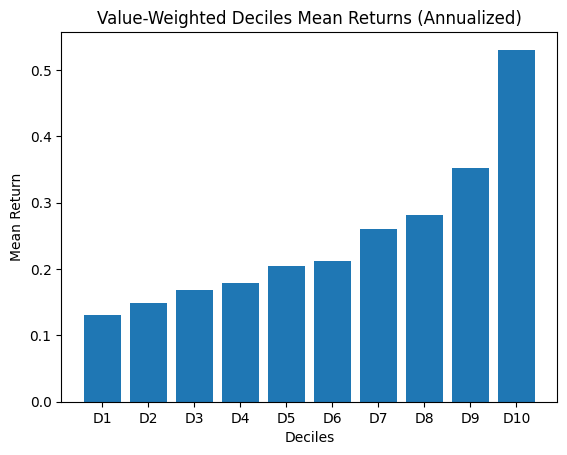

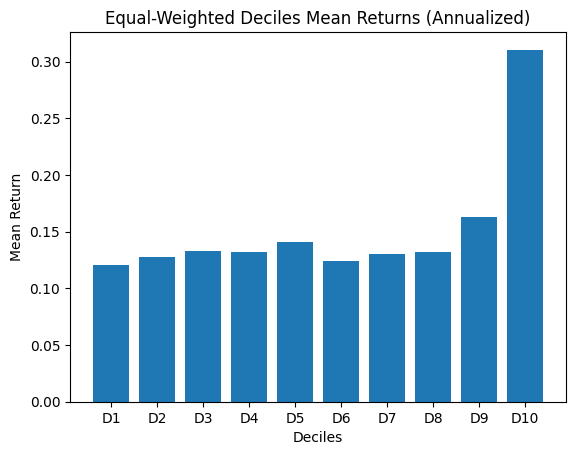

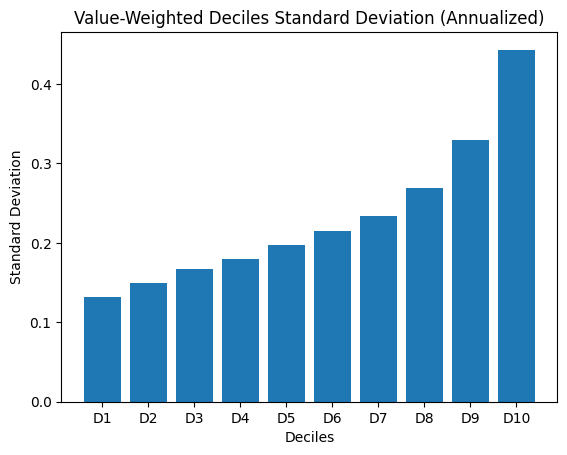

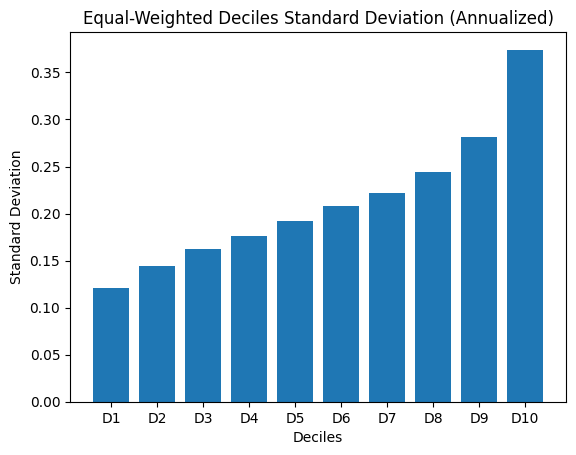

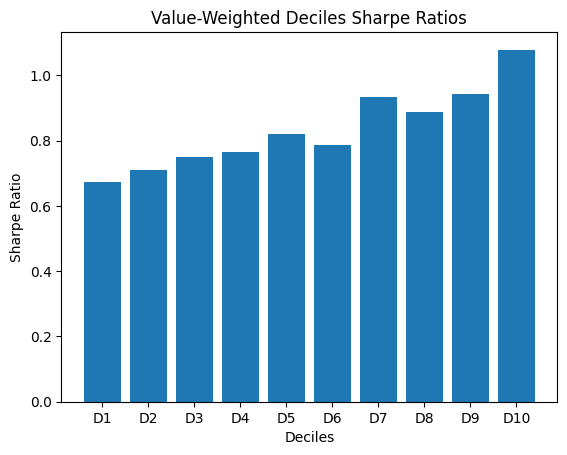

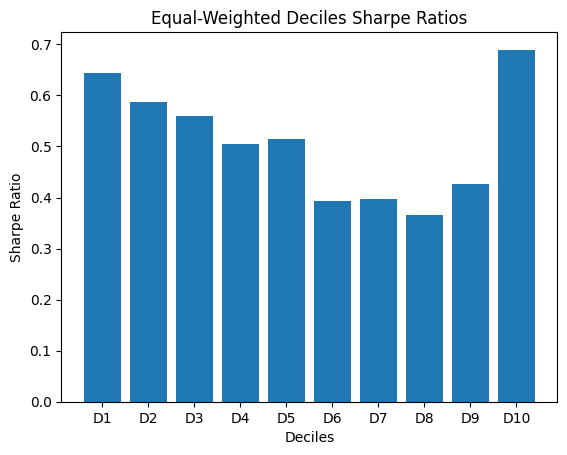

In [233]:
file_name = 'data_with_IV.csv'

def compute_IV_deciles(file_name, do_plot=True):
    # load data
    data = pd.read_csv(file_name, sep=',', parse_dates=['date'])
    data['IV_Q'] = data.groupby('date')['idiosyncratic_volatility'].transform(lambda x: pd.qcut(x, 10,labels=False, duplicates='drop'))

    # 2. Market Weights within deciles
    data['vw_Q'] = data['mcap_l']/data.groupby(['date','IV_Q'])['mcap_l'].transform('sum')

    # 3. VW Portfolios
    data['IV_ret_vw'] = data['vw_Q']*data['Rn']
    ret_vw = data.groupby(['date','IV_Q'])['IV_ret_vw'].sum().reset_index()
    vw_ret_mean = ret_vw.groupby('IV_Q')['IV_ret_vw'].mean()

    # 4. Equal-Weighted portfolios
    ret_ew = data.groupby(['date','IV_Q'])['Rn'].mean().reset_index()
    ew_ret_mean = ret_ew.groupby('IV_Q')['Rn'].mean()
    # Calculate standard deviations
    vw_ret_std = ret_vw.groupby('IV_Q')['IV_ret_vw'].std()
    ew_ret_std = ret_ew.groupby('IV_Q')['Rn'].std()

    # Calculate Sharpe Ratios

    # compute the risk-free rate
    rf = data.groupby(['date', 'IV_Q'])['rf'].mean().reset_index()

    # compute the excess returns
    ret_vw['excess'] = ret_vw['IV_ret_vw'] - rf['rf']
    ret_ew['excess'] = ret_ew['Rn'] - rf['rf']

    # compute the Sharpe Ratios
    vw_sharpe_ratio = ret_vw.groupby('IV_Q')['excess'].mean() / vw_ret_std
    ew_sharpe_ratio = ret_ew.groupby('IV_Q')['excess'].mean() / ew_ret_std

    # save data with the IV
    data.to_csv('data_with_IV2.csv', sep=',',index=False)
    # 5. Plot Histograms
    deciles = ['D' + str(x) for x in np.arange(1, 11)]

    if do_plot:

        directory = 'Plots/Part5/'
        #save plots
        # Plot VW mean returns
        plt.bar(deciles, vw_ret_mean * 12)
        plt.title('Value-Weighted Deciles Mean Returns (Annualized)')
        plt.xlabel('Deciles')
        plt.ylabel('Mean Return')
        plt.savefig(directory + 'P5vw_ret_mean.png')
        plt.show()

        # Plot EW mean returns
        plt.bar(deciles, ew_ret_mean * 12)
        plt.title('Equal-Weighted Deciles Mean Returns (Annualized)')
        plt.xlabel('Deciles')
        plt.ylabel('Mean Return')
        plt.savefig(directory + 'P5ew_ret_mean.png')
        plt.show()

        # Plot VW standard deviations
        plt.bar(deciles, vw_ret_std * np.sqrt(12))
        plt.title('Value-Weighted Deciles Standard Deviation (Annualized)')
        plt.xlabel('Deciles')
        plt.ylabel('Standard Deviation')
        plt.savefig(directory + 'P5vw_ret_std.png')
        plt.show()

        # Plot EW standard deviations
        plt.bar(deciles, ew_ret_std * np.sqrt(12))
        plt.title('Equal-Weighted Deciles Standard Deviation (Annualized)')
        plt.xlabel('Deciles')
        plt.ylabel('Standard Deviation')
        plt.savefig(directory + 'P5ew_ret_std.png')
        plt.show()

        # Plot VW Sharpe ratios
        plt.bar(deciles, vw_sharpe_ratio * np.sqrt(12))
        plt.title('Value-Weighted Deciles Sharpe Ratios')
        plt.xlabel('Deciles')
        plt.ylabel('Sharpe Ratio')
        plt.savefig(directory + 'P5vw_sharpe_ratio.png')
        plt.show()

        # Plot EW Sharpe ratios
        plt.bar(deciles, ew_sharpe_ratio * np.sqrt(12))
        plt.title('Equal-Weighted Deciles Sharpe Ratios')
        plt.xlabel('Deciles')
        plt.ylabel('Sharpe Ratio')
        plt.savefig(directory + 'P5ew_sharpe_ratio.png')
        plt.show()

compute_IV_deciles(file_name)


In [234]:
file_name = 'data_with_IV2.csv'
def IV_equal_weigthed_factor(file_name):
    # load data
    data = pd.read_csv(file_name, sep=',', parse_dates=['date'])

    # 1. Compute the long and short legs of the strategy
    long_leg = data[data['IV_Q'] >= 7].groupby('date')['Rn'].mean().reset_index()
    short_leg = data[data['IV_Q'] < 3].groupby('date')['Rn'].mean().reset_index()

    # 2. Compute the excess returns
    rf = data.groupby(['date', 'IV_Q'])['rf'].mean().reset_index()

    long_leg['excess'] = long_leg['Rn'] - rf['rf']
    short_leg['excess'] = short_leg['Rn'] - rf['rf']

    # 3. Compute the mean, excess mean, standard deviation, and Sharpe ratios
    long_mean = long_leg['Rn'].mean() * 12
    short_mean = short_leg['Rn'].mean() *12

    long_mean_e = long_leg['excess'].mean() *12
    short_mean_e = short_leg['excess'].mean() * 12

    long_std = long_leg['Rn'].std() * np.sqrt(12)
    short_std = short_leg['Rn'].std() * np.sqrt(12)

    long_sharpe_ratio = long_mean_e / long_std
    short_sharpe_ratio = short_mean_e / short_std

    # Long minus short factor strategy
    factor = long_leg.set_index("date") - short_leg.set_index("date")
    factor = factor.reset_index()
    factor['excess'] = factor['Rn'] - rf['rf']

    factor_mean = factor['Rn'].mean() * 12
    factor_mean_e = factor['excess'].mean() * 12
    factor_std = factor['Rn'].std() * np.sqrt(12)
    factor_sharpe_ratio = factor_mean_e / factor_std

    # 4. Print the results
    print('Long Leg Mean Return:', long_mean)
    print('Short Leg Mean Return:', short_mean)
    print('Long Leg Standard Deviation:', long_std)
    print('Short Leg Standard Deviation:', short_std)
    print('Long Leg Sharpe Ratio:', long_sharpe_ratio)
    print('Short Leg Sharpe Ratio:', short_sharpe_ratio)
    print('Factor Mean Return:', factor_mean)
    print('Factor Standard Deviation:', factor_std)
    print('Factor Sharpe Ratio:', factor_sharpe_ratio)

    # Test if the factor strategy has an average return that is statistically significantly different from zero

    # 1. Compute the t-statistic
    t_stat = factor_mean / (factor_std / np.sqrt(len(factor)))

    # 2. Compute the p-value
    p_value = 1 - stats.norm.cdf(t_stat)

    # 3. Print the results
    print('T-Statistic:', t_stat)
    print('P-Value:', p_value)

    # 4. Check if the p-value is less than 0.05
    if p_value < 0.05:
        print('The factor strategy has an average return that is statistically significantly different from zero.')
    else:
        print('The factor strategy does not have an average return that is statistically significantly different from zero.')

IV_equal_weigthed_factor(file_name)

Long Leg Mean Return: 0.1881106265304915
Short Leg Mean Return: 0.12760485264063248
Long Leg Standard Deviation: 0.2845354776830849
Short Leg Standard Deviation: 0.1388414516056226
Long Leg Sharpe Ratio: 0.46428368545075854
Short Leg Sharpe Ratio: 0.5156918593282426
Factor Mean Return: 0.060505773889859005
Factor Standard Deviation: 0.2022864396824032
Factor Sharpe Ratio: 0.02224730232351674
T-Statistic: 7.608204714967965
P-Value: 1.3877787807814457e-14
The factor strategy has an average return that is statistically significantly different from zero.


Value weighted factor strategy

In [235]:
file_name = 'data_with_IV2.csv'
strat_file = 'strat.csv'
def IV_value_weigthed_factor(file_name):
    # load data
    data = pd.read_csv(file_name, sep=',', parse_dates=['date'])
    #1. Compute the long and short legs of the strategy
    vw_long_leg = data[data['IV_Q'] >= 7].groupby('date')['IV_ret_vw'].sum().reset_index()
    vw_short_leg = data[data['IV_Q'] < 3].groupby('date')['IV_ret_vw'].sum().reset_index()

    # 2. Compute the excess returns
    rf = data.groupby(['date', 'IV_Q'])['rf'].mean().reset_index()

    vw_long_leg['excess'] = vw_long_leg['IV_ret_vw'] - rf['rf']
    vw_short_leg['excess'] = vw_short_leg['IV_ret_vw'] - rf['rf']

    # 3. Compute the mean, excess mean, standard deviation, and Sharpe ratios
    long_mean = vw_long_leg['IV_ret_vw'].mean() * 12
    short_mean = vw_short_leg['IV_ret_vw'].mean() * 12

    long_mean_e = vw_long_leg['excess'].mean() * 12
    short_mean_e = vw_short_leg['excess'].mean() * 12

    long_std = vw_long_leg['IV_ret_vw'].std() * np.sqrt(12)
    short_std = vw_short_leg['IV_ret_vw'].std() * np.sqrt(12)

    long_sharpe_ratio = long_mean_e / long_std
    short_sharpe_ratio = short_mean_e / short_std

    # Long minus short factor strategy
    factor = vw_long_leg.set_index("date") - vw_short_leg.set_index("date")
    factor = factor.reset_index()
    factor['excess'] = factor['IV_ret_vw'] - rf['rf']

    factor_mean = factor['IV_ret_vw'].mean()
    factor_mean_e = factor['excess'].mean()
    factor_std = factor['IV_ret_vw'].std()
    factor_sharpe_ratio = factor_mean_e / factor_std

    # 4. Print the results
    print('Long Leg Mean Return:', long_mean)
    print('Short Leg Mean Return:', short_mean)
    print('Long Leg Standard Deviation:', long_std)
    print('Short Leg Standard Deviation:', short_std)
    print('Long Leg Sharpe Ratio:', long_sharpe_ratio)
    print('Short Leg Sharpe Ratio:', short_sharpe_ratio)
    print('Factor Mean Return:', factor_mean)
    print('Factor Standard Deviation:', factor_std)
    print('Factor Sharpe Ratio:', factor_sharpe_ratio)

    # Test if the factor strategy has an average return that is statistically significantly different from zero

    # 1. Compute the t-statistic
    t_stat = factor_mean / (factor_std / np.sqrt(len(factor)))

    # 2. Compute the p-value
    p_value = 1 - stats.norm.cdf(t_stat)

    # 3. Print the results
    print('T-Statistic:', t_stat)
    print('P-Value:', p_value)

    # 4. Check if the p-value is less than 0.05
    if p_value < 0.05:
        print('The factor strategy has an average return that is statistically significantly different from zero.')
    else:
        print('The factor strategy does not have an average return that is statistically significantly different from zero.')

    # load strategy data
    strat = pd.read_csv(strat_file, sep=',', parse_dates=['date'])
    strat = strat.merge(factor[['date','IV_ret_vw']], on='date', how='left')
    # rename columns to IV and MOM
    strat = strat.rename(columns={'IV_ret_vw':'IV','MOM_ret_vw':'MOM'})
    # save strategy data
    strat.to_csv('strat.csv', sep=',',index=False) # export data

IV_value_weigthed_factor(file_name)

Long Leg Mean Return: 1.035207548975377
Short Leg Mean Return: 0.44738154273693664
Long Leg Standard Deviation: 0.8806072299901672
Short Leg Standard Deviation: 0.43457874111935957
Long Leg Sharpe Ratio: 1.1119623701885957
Short Leg Sharpe Ratio: 0.9005873030479102
Factor Mean Return: 0.04898550051987
Factor Standard Deviation: 0.1954589538812774
Factor Sharpe Ratio: 0.22674008590535646
T-Statistic: 6.374764129102841
P-Value: 9.162237635251813e-11
The factor strategy has an average return that is statistically significantly different from zero.


# 6 Optimal Fund Portfolio Return (STRAT)

In [236]:
strat_file = 'strat.csv'
def strat_portfolio(strat_file):
    # load data
    strat = pd.read_csv(strat_file, sep=',', parse_dates=['date'])
    
    # Equal weight strategy
    strat['STRAT1'] = (strat['BAB2'] + strat['IV'] + strat['MOM'])/3

    # Window size equal to data length
    number_of_rows = len(strat)


    # Risk-Parity strategy
    rolling_vol = strat[['BAB2', 'IV', 'MOM']].rolling(window = 60,min_periods=36).std()
    weights = 1 / rolling_vol
    # Normalize the weights
    weights = weights.div(weights.sum(axis=1), axis=0)
    strat['STRAT2'] = (weights['BAB2'] * strat['BAB2'] + weights['IV'] * strat['IV'] + weights['MOM'] * strat['MOM'])
    strat['STRAT2_bab_w'] = weights['BAB2']
    strat['STRAT2_mom_w'] = weights['MOM']
    strat['STRAT2_iv_w'] = weights['IV']

    # Mean-variance optimal combination
    rolling_mean = strat[['BAB2', 'IV', 'MOM']].rolling(window = 60, min_periods=36).mean()
    rolling_cov = strat[['BAB2', 'IV', 'MOM']].rolling(window = 60, min_periods=36).cov()

    # w_tan = Cov^(-1) * (mu - Rf * 1) / 1.T * Cov^(-1) * (mu - Rf * 1)

    # Iterate over the rolling windows
    optimal_weights = []
    for i in range(number_of_rows):
        mu = rolling_mean.iloc[i].values
        cov = rolling_cov.loc[rolling_cov.index.get_level_values(0) == i].droplevel(0)
        ones = np.ones(len(mu))
        rf = strat['rf'].iloc[i]
        w_tan = np.linalg.inv(cov).dot((mu - rf * ones)) / (ones.T.dot(np.linalg.inv(cov).dot((mu - rf * ones))))
        optimal_weights.append(w_tan)

    optimal_weights = pd.DataFrame(optimal_weights, columns = ['BAB2', 'IV', 'MOM'])
    strat['STRAT3'] = (optimal_weights['BAB2'] * strat['BAB2'] + optimal_weights['IV'] * strat['IV'] + optimal_weights['MOM'] * strat['MOM'])

    # Calculate the annualized volatility and mean of the STRAT1, STRAT2, and STRAT3 strategies
    strat1_mean = strat['STRAT1'].mean() * 12
    strat1_std = strat['STRAT1'].std() * np.sqrt(12)
    excess_strat1 = strat['STRAT1'] - strat['rf']
    strat1_sharpe = excess_strat1.mean() / strat["STRAT1"].std() * np.sqrt(12)

    strat2_mean = strat['STRAT2'].mean() * 12
    strat2_std = strat['STRAT2'].std() * np.sqrt(12)
    excess_strat2 = strat['STRAT2'] - strat['rf']
    strat2_sharpe = excess_strat2.mean() / strat["STRAT2"].std() * np.sqrt(12)

    strat3_mean = strat['STRAT3'].mean() * 12
    strat3_std = strat['STRAT3'].std() * np.sqrt(12)
    excess_strat3 = strat['STRAT3'] - strat['rf']
    strat3_sharpe = excess_strat3.mean() / strat["STRAT3"].std() * np.sqrt(12)

    # Print the results
    print('Equal Weighted Strategy:')
    print('Mean:', strat1_mean)
    print('Standard Deviation:', strat1_std)
    print('Sharpe Ratio:', strat1_sharpe)
    print("\n")

    print('Risk-Parity Strategy:')
    print('Mean:', strat2_mean)
    print('Standard Deviation:', strat2_std)
    print('Sharpe Ratio:', strat2_sharpe)
    print("\n")

    print('Mean-Variance Optimal Strategy:')
    print('Mean:', strat3_mean)
    print('Standard Deviation:', strat3_std)
    print('Sharpe Ratio:', strat3_sharpe)

    # Save the data
    strat.to_csv('strat2.csv', sep=',',index=False) # export data

    return strat1_std, strat2_std, strat3_std

strat1_std, strat2_std, strat3_std = strat_portfolio(strat_file)

Equal Weighted Strategy:
Mean: 0.2529728795931482
Standard Deviation: 0.24906353046477178
Sharpe Ratio: 0.8450018957468907


Risk-Parity Strategy:
Mean: 0.1812775648120134
Standard Deviation: 0.15353559003351497
Sharpe Ratio: 0.9048212054814434


Mean-Variance Optimal Strategy:
Mean: 0.328485752171191
Standard Deviation: 1.5286434628068732
Sharpe Ratio: 0.18717932073723637


In [237]:
strat_file = 'strat2.csv'
def find_c(strat_file, strat1_std, strat2_std, strat3_std):

    # load data
    strat = pd.read_csv(strat_file, sep=',', parse_dates=['date'])
    # Now find c such that the average annual volatility of the fund is 10% in each case
    c1 = 0.1 / strat1_std
    c2 = 0.1 / strat2_std
    c3 = 0.1 / strat3_std

    # Calculate the fund returns
    strat['fund1'] = strat['rf'] + c1 * strat['STRAT1']
    strat['fund2'] = strat['rf'] + c2 * strat['STRAT2']
    strat['fund3'] = strat['rf'] + c3 * strat['STRAT3']

    # Calculate the annualized volatility and mean of the fund returns
    fund1_mean = strat['fund1'].mean() * 12
    fund1_std = strat['fund1'].std() * np.sqrt(12)
    excess_fund1 = strat['fund1'] - strat['rf']
    fund1_sharpe = excess_fund1.mean() / strat["fund1"].std() * np.sqrt(12)

    fund2_mean = strat['fund2'].mean() * 12
    fund2_std = strat['fund2'].std() * np.sqrt(12)
    excess_fund2 = strat['fund2'] - strat['rf']
    fund2_sharpe = excess_fund2.mean() / strat["fund2"].std() * np.sqrt(12)

    fund3_mean = strat['fund3'].mean() * 12
    fund3_std = strat['fund3'].std() * np.sqrt(12)
    excess_fund3 = strat['fund3'] - strat['rf']
    fund3_sharpe = excess_fund3.mean() / strat["fund3"].std() * np.sqrt(12)

    # Print the results

    # Print the c
    print('c1:', c1)
    print('c2:', c2)
    print('c3:', c3)
    print("\n")

    print('Equal Weighted Fund:')
    print('Mean:', fund1_mean)
    print('Standard Deviation:', fund1_std)
    print('Sharpe Ratio:', fund1_sharpe)
    print("\n")

    print('Risk-Parity Fund:')
    print('Mean:', fund2_mean)
    print('Standard Deviation:', fund2_std)
    print('Sharpe Ratio:', fund2_sharpe)
    print("\n")

    print('Mean-Variance Optimal Fund:')
    print('Mean:', fund3_mean)
    print('Standard Deviation:', fund3_std)
    print('Sharpe Ratio:', fund3_sharpe)

    # Save the data
    strat.to_csv('strat3.csv', sep=',',index=False) # export data

    return c2

c2 = find_c(strat_file, strat1_std, strat2_std, strat3_std)

c1: 0.40150398500090434
c2: 0.6513147862210398
c3: 0.06541747793588273


Equal Weighted Fund:
Mean: 0.14408334344280546
Standard Deviation: 0.10085177698451452
Sharpe Ratio: 1.0071177949536634


Risk-Parity Fund:
Mean: 0.1604240655257907
Standard Deviation: 0.10060437233667531
Sharpe Ratio: 1.1735947019985042


Mean-Variance Optimal Fund:
Mean: 0.0638440165984944
Standard Deviation: 0.10012299064473018
Sharpe Ratio: 0.2146231280801414


# 7 Performance and risk analysis for the Fund strategy

### a)

In [238]:
industries =['NoDur','Durbl','Manuf','Enrgy','Chems','BusEq','Telcm','Utils','Shops','Hlth','Money','Other']

In [239]:
file_name = 'data7/12_Industry_Portfolios.CSV'

def get_industry_returns(file_name, industries):
    # Get the Industry Portfolio returns
    from io import StringIO

    # Function to skip problematic rows and clean the data
    def skip_and_clean_rows(file_path):
        with open(file_path, 'r') as file:
            lines = file.readlines()

        # Keep lines that start with numeric values or are part of the header, and strip leading/trailing whitespace
        valid_lines = [line.strip() for line in lines if line.strip().split(',')[0].strip().isdigit() or line.startswith('date')]
        
        return valid_lines

    # Get the cleaned lines
    cleaned_lines = skip_and_clean_rows(file_name)

    # Create a new dataframe from the cleaned lines
    industry_returns = pd.read_csv(StringIO('\n'.join(cleaned_lines)), names=['date']+industries)

    # Convert the 'Date' column to datetime format
    industry_returns['date'] = pd.to_datetime(industry_returns['date'], format='%Y%m', errors='coerce')
    industry_returns.columns = ['date', 'NoDur', 'Durbl', 'Manuf', 'Enrgy', 'Chems', 'BusEq', 'Telcm', 'Utils', 'Shops', 'Hlth', 'Money', 'Other']

    # save data
    industry_returns.to_csv('industry_returns.csv', sep=',',index=False) # export data

get_industry_returns(file_name, industries)

In [240]:
file_name = 'data7/F-F_Research_Data_5_Factors_2x3.csv'
def get_french_factors(file_name):
    french_factors = pd.read_csv(file_name, skiprows=3)

    # Rename the date column for clarity
    french_factors.rename(columns={'Unnamed: 0': 'date'}, inplace=True)

    # Ensure all entries in 'Date' column are strings
    french_factors['date'] = french_factors['date'].astype(str)

    # Remove invalid date entries
    french_factors = french_factors[~french_factors['date'].str.contains(" ")]

    # Convert the 'Date' column to datetime format
    french_factors['date'] = pd.to_datetime(french_factors['date'], format='%Y%m', errors='coerce')

    # Drop rows with NaT in 'Date' column
    french_factors.dropna(subset=['date'], inplace=True)
    # Rename columns for clarity
    french_factors.columns = ['date', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']
    
    # save data
    french_factors.to_csv('french_factors.csv', sep=',',index=False) # export data

get_french_factors(file_name)

In [241]:
strat_file = 'strat3.csv'
industries_returns_file = 'industry_returns.csv'
french_factors_file = 'french_factors.csv'

def beta_estimate_strat_port(strat_file, industries_returns_file, french_factors_file):
    # load data
    strategy_returns = pd.read_csv(strat_file, sep=',', parse_dates=['date'])
    industries_returns = pd.read_csv(industries_returns_file, sep=',', parse_dates=['date'])
    french_factors = pd.read_csv(french_factors_file, sep=',', parse_dates=['date'])

    # Merge data on 'date'
    merged_data = pd.merge(strategy_returns, french_factors, on='date')
    merged_data = pd.merge(merged_data, industries_returns, on='date')

    # Drop rows with missing values
    merged_data = merged_data.dropna()

    # Extract the dependent variable 
    Y = merged_data['fund2'] - merged_data['rf']

    # Extract the independent variables (12 industry returns and Fama-French 5 factors)
    X = merged_data[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'NoDur', 'Durbl', 'Manuf', 'Enrgy', 'Chems', 'BusEq', 'Telcm', 'Utils', 'Shops', 'Hlth', 'Money', 'Other']].astype(float)

    # Add a constant term for the intercept
    X = sm.add_constant(X)

    # Perform the regression
    model = sm.OLS(Y, X).fit()

    # Display the regression results
    print(model.summary())
    return model

model = beta_estimate_strat_port(strat_file, industries_returns_file, french_factors_file)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.355
Model:                            OLS   Adj. R-squared:                  0.350
Method:                 Least Squares   F-statistic:                     78.64
Date:                Fri, 21 Jun 2024   Prob (F-statistic):          2.10e-216
Time:                        22:46:26   Log-Likelihood:                 5743.2
No. Observations:                2448   AIC:                        -1.145e+04
Df Residuals:                    2430   BIC:                        -1.135e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0068      0.001     10.907      0.0

### b)

In [242]:
# with beta
file_name = 'data_with_beta_n.csv'
def data_with_industries_with_beta(file_name):

    # Load the data
    data = pd.read_csv(file_name, sep=',', parse_dates=['date'])
    data = data.rename(columns={'siccd':'SIC'})
    
    sic_ranges = {
        "NoDur": [(100, 999), (2000, 2399), (2700, 2749), (2770, 2799), (3100, 3199), (3940, 3989)],
        "Durbl": [(2500, 2519), (2590, 2599), (3630, 3659), (3710, 3711), (3714, 3714), (3716, 3716), (3750, 3751), (3792, 3792), (3900, 3939), (3990, 3999)],
        "Manuf": [(2520, 2589), (2600, 2699), (2750, 2769), (3000, 3099), (3200, 3569), (3580, 3629), (3700, 3709), (3712, 3713), (3715, 3715), (3717, 3749), (3752, 3791), (3793, 3799), (3830, 3839), (3860, 3899)],
        "Enrgy": [(1200, 1399), (2900, 2999)],
        "Chems": [(2800, 2829), (2840, 2899)],
        "BusEq": [(3570, 3579), (3660, 3692), (3694, 3699), (3810, 3829), (7370, 7379)],
        "Telcm": [(4800, 4899)],
        "Utils": [(4900, 4949)],
        "Shops": [(5000, 5999), (7200, 7299), (7600, 7699)],
        "Hlth": [(2830, 2839), (3693, 3693), (3840, 3859), (8000, 8099)],
        "Money": [(6000, 6999)],
        "Other": []  # assuming no ranges are defined for 'Other' in the file
    }

    # Function to determine the industry based on SIC code
    def get_industry(sic_code):
        for industry, ranges in sic_ranges.items():
            for lower, upper in ranges:
                if lower <= sic_code <= upper:
                    return industry
        return "Other"

    # Add columns for each industry
    for industry in sic_ranges.keys():
        data[industry] = 0

    # Update the columns based on the SIC code
    for index, row in data.iterrows():
        industry = get_industry(row['SIC'])
        if industry in sic_ranges:
            data.at[index, industry] = 1
            
    # Save the updated data
    data.to_csv('data_with_industries_with_beta_n.csv', index=False)
data_with_industries_with_beta(file_name)



In [243]:
file_beta = 'data_with_beta_n.csv'
file_mom = 'data_with_momentum2.csv'
file_IV = 'data_with_IV2.csv'
def create_factor_weight_7(file_beta, file_mom, file_IV):
    # load data
    data = pd.read_csv(file_beta, sep=',', parse_dates=['date'])
    
    # Create factor weights for exercise 7
    data['w_bab'] = 1 / data['beta']
    data['w_bab'] = data['w_bab'] / data.groupby('date')['w_bab'].transform('sum')

    # Create new a new dataframe to store the bab weights
    factor_weights_bab = data[['date', 'permno', 'w_bab']]
    
    # load data
    data = pd.read_csv(file_mom, sep=',', parse_dates=['date'])

    # Storing factor weights for exercise 7
    data['w_L'] = (data['Momentum'] >= 7)*data['mcap_l']
    data['w_S'] = (data['Momentum'] <= 2)*data['mcap_l']
    data['w_L'] = data['w_L']/data.groupby(['date'])['w_L'].transform('sum')
    data['w_S'] = data['w_S']/data.groupby(['date'])['w_S'].transform('sum')
    data['w_Mom'] = data['w_L'] - data['w_S']

    factor_weights_mom = data[['date', 'permno', 'w_Mom']]

    factor_weights = factor_weights_bab.merge(factor_weights_mom, on=['date', 'permno'], how='left')

    # load data
    data = pd.read_csv(file_IV, sep=',', parse_dates=['date'])
    data['w_L'] = (data['IV_Q']>= 7)*data['mcap_l']
    data['w_S'] = (data['IV_Q']<=2)*data['mcap_l']
    data['w_L'] = data['w_L']/data.groupby(['date'])['w_L'].transform('sum')
    data['w_S'] = data['w_S']/data.groupby(['date'])['w_S'].transform('sum')
    data['w_IV'] = data['w_L'] - data['w_S']

    factor_weights_iv = data[['date', 'permno', 'w_IV']]

    factor_weights = factor_weights.merge(factor_weights_iv, on=['date', 'permno'], how='left')

    factor_weights.to_csv('factor_weights.csv', sep=',',index=False)

create_factor_weight_7(file_beta, file_mom, file_IV)

KeyError: 'IV_Q'

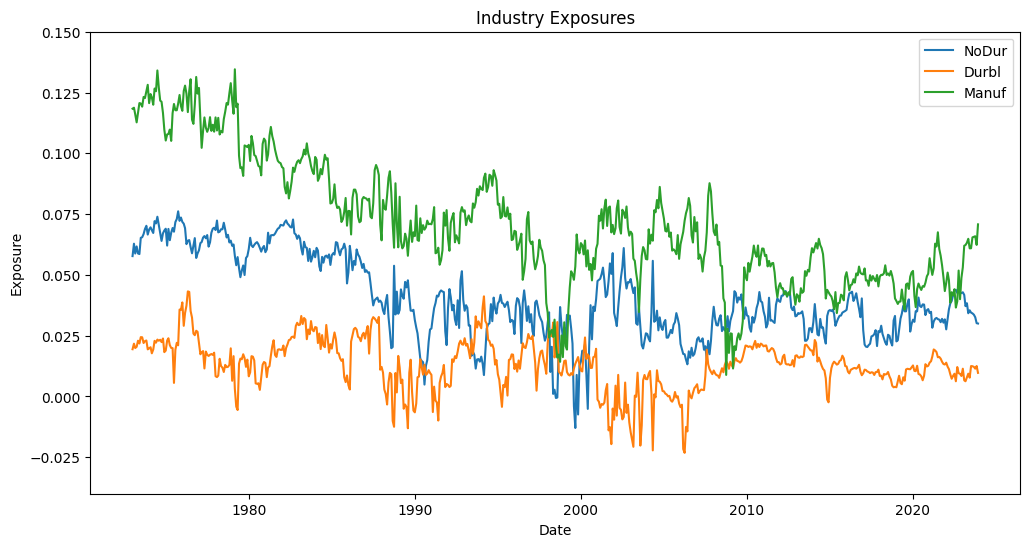

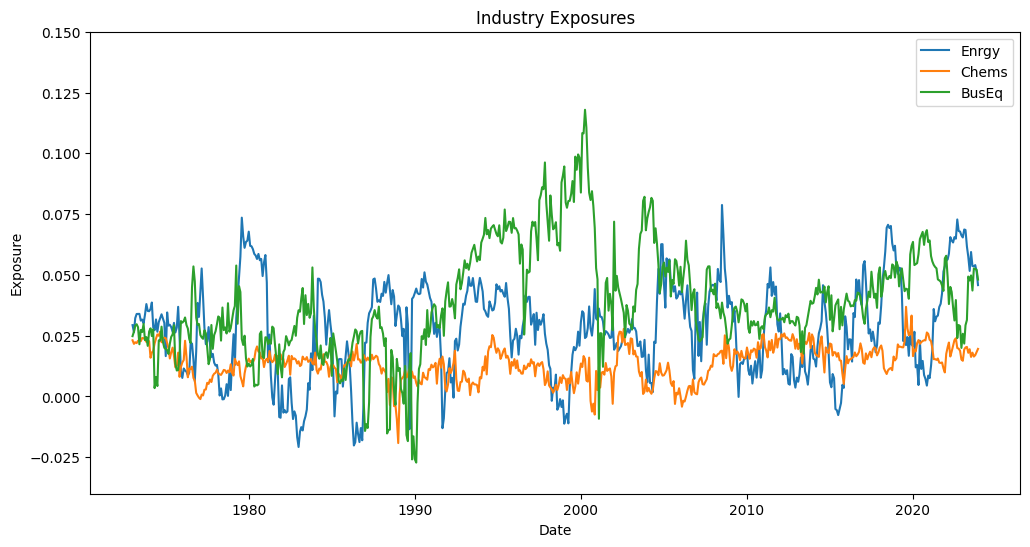

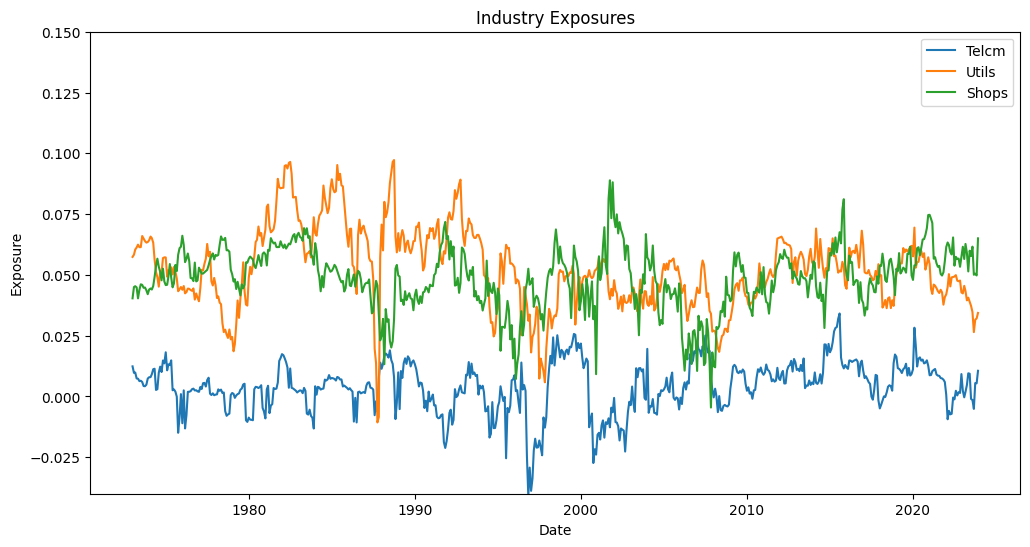

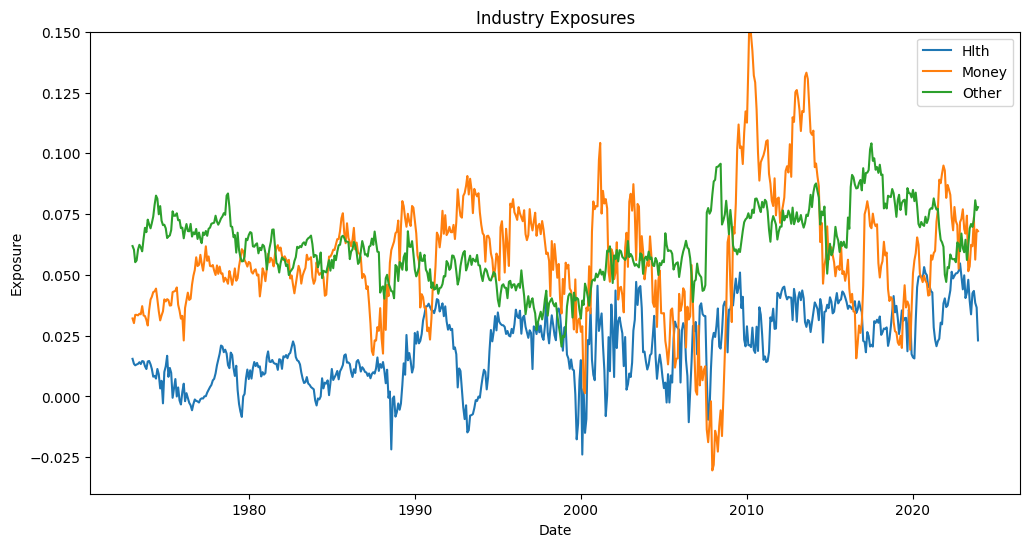

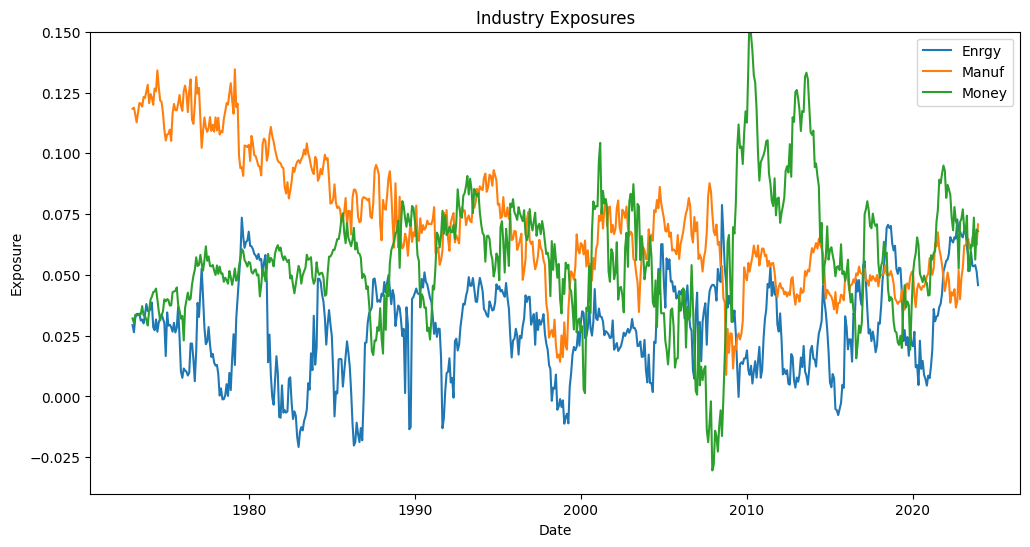

In [ ]:
file_name = 'data_with_industries_with_beta_n.csv'
factor_weights_file = 'factor_weights.csv'
strat_file = 'strat3.csv'

def compute_conditional_exposure(file_name, factor_weights_file, strat_file, c2):
    # load data
    data = pd.read_csv(file_name, sep=',', parse_dates=['date'])
    factor_weights = pd.read_csv(factor_weights_file, sep=',', parse_dates=['date'])
    strat = pd.read_csv(strat_file, sep=',', parse_dates=['date'])
    

    # Merge the data
    data = data.merge(factor_weights, on=['date', 'permno'], how='left')

    # Calculate the beta of each factor at each time t
    data['beta_BAB2'] = data['beta'] * data['w_bab']
    data['beta_IV'] = data['beta'] * data['w_IV']
    data['beta_MOM'] = data['beta'] * data['w_Mom']

    # Calculate the weighted beta of each industry at each time t by iterating through industries
    for industry in industries:
        data[industry+"_bab"] = data[industry] * data['w_bab']
        data[industry+"_iv"] = data[industry] * data['w_IV']
        data[industry+"_mom"] = data[industry] * data['w_Mom']

    # Create temporary dataframe to store the factor betas
    tmp = data[['date','permno', 'beta_BAB2', 'beta_IV', 'beta_MOM']].copy()

    # Add industries to tmp
    for industry in industries:
        tmp[industry+"_bab"] = data[industry+"_bab"]
        tmp[industry+"_iv"] = data[industry+"_iv"]
        tmp[industry+"_mom"] = data[industry+"_mom"]

    # Compute the new beta as the sum of each weighted beta at each time t
    tmp['beta_BAB2'] = tmp.groupby('date')['beta_BAB2'].transform('sum')
    tmp['beta_IV'] = tmp.groupby('date')['beta_IV'].transform('sum')
    tmp['beta_MOM'] = tmp.groupby('date')['beta_MOM'].transform('sum')

    # Compute the new beta for each industry at each time t
    for industry in industries:
        tmp[industry+"_bab"] = tmp.groupby('date')[industry+"_bab"].transform('sum')
        tmp[industry+"_iv"] = tmp.groupby('date')[industry+"_iv"].transform('sum')
        tmp[industry+"_mom"] = tmp.groupby('date')[industry+"_mom"].transform('sum')


    # Drop column permno
    tmp = tmp.drop(columns=['permno'])    
    # Merge tmp with strat on date
    strat = strat.merge(tmp, on=['date'], how='left')
    # Drop duplicates in strat
    strat = strat.drop_duplicates()

    # Drop every nan value in strat
    strat = strat.dropna()
    strat = strat.reset_index()

    strat["STRAT2_BETA_MKT"] = c2*(strat["STRAT2_bab_w"] * 0 + strat["STRAT2_iv_w"] * strat["beta_IV"] + strat["STRAT2_mom_w"] * strat["beta_MOM"])

    for industry in industries:
        strat["STRAT2_BETA_" + industry] = c2*(strat["STRAT2_bab_w"] * strat[industry + "_bab"] + strat["STRAT2_iv_w"] * strat[industry + "_iv"] + strat["STRAT2_mom_w"] * strat[industry + "_mom"])

    # Save the data
    strat.to_csv('strat_with_exposure.csv', sep=',',index=False)
    # do 4 plots Exposure for every 3 ndustry with a fix scale for y axis
    directory = 'Plots/Part7/'

    for i in range(0, len(industries), 3):

        # Extract the industry names for the current plot
        industry_names = industries[i:i+3]

        # Create a figure and axis
        fig, ax = plt.subplots(1, 1, figsize=(12, 6))

        # Plot the industry exposures
        for industry in industry_names:
            ax.plot(strat['date'], strat["STRAT2_BETA_" + industry], label=industry)

        # Set the title and labels
        ax.set_title('Industry Exposures')
        ax.set_xlabel('Date')
        ax.set_ylabel('Exposure')
        ax.legend()
        ax.set_ylim(-0.04, 0.150)
        plt.savefig(directory + 'Exposure_' + str(i) + '.png')
        plt.show()

    industry_selected = ['Enrgy', 'Manuf', 'Money']
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))

    # Plot the industry exposures
    for industry in industry_selected:
        ax.plot(strat['date'], strat["STRAT2_BETA_" + industry], label=industry)

    # Set the title and labels
    ax.set_title('Industry Exposures')
    ax.set_xlabel('Date')
    ax.set_ylabel('Exposure')
    ax.legend()
    ax.set_ylim(-0.04, 0.150)
    plt.savefig(directory + 'Exposure_selected.png')
    plt.show()

compute_conditional_exposure(file_name, factor_weights_file, strat_file, c2)


### c) Use strat, industry_returns and industry_factors

In [ ]:
industry_returns_file = 'industry_returns.csv'
strategy_file = 'strat_with_exposure.csv'

def hedged_portofolio(industries_returns_file, strategy_file):
    # Load the data
    industry_returns = pd.read_csv(industries_returns_file, sep=',', parse_dates=['date'])
    strat = pd.read_csv(strategy_file, sep=',', parse_dates=['date'])

    strat['fund2_HEDGED'] = strat['fund2'] - strat['STRAT2_BETA_NoDur']*industry_returns['NoDur'] - strat['STRAT2_BETA_Durbl']*industry_returns['Durbl'] - strat['STRAT2_BETA_Manuf']*industry_returns['Manuf'] - strat['STRAT2_BETA_Enrgy']*industry_returns['Enrgy'] - strat['STRAT2_BETA_Chems']*industry_returns['Chems'] - strat['STRAT2_BETA_BusEq']*industry_returns['BusEq'] - strat['STRAT2_BETA_Telcm']*industry_returns['Telcm'] - strat['STRAT2_BETA_Utils']*industry_returns['Utils'] - strat['STRAT2_BETA_Shops']*industry_returns['Shops'] - strat['STRAT2_BETA_Hlth']*industry_returns['Hlth'] - strat['STRAT2_BETA_Money']*industry_returns['Money'] - strat['STRAT2_BETA_Other']*industry_returns['Other']
    # report the average return, the standard deviation, and the Sharpe ratio of the hedged fund
    fund2_hedged_mean = strat['fund2_HEDGED'].mean() * 12
    fund2_hedged_std = strat['fund2_HEDGED'].std() * np.sqrt(12)
    excess_fund2_hedged = strat['fund2_HEDGED'] - strat['rf']
    fund2_hedged_sharpe = excess_fund2_hedged.mean() / strat["fund2_HEDGED"].std() * np.sqrt(12)

    print('Hedged Fund:')
    print('Mean:', fund2_hedged_mean)
    print('Standard Deviation:', fund2_hedged_std)
    print('Sharpe Ratio:', fund2_hedged_sharpe)

hedged_portofolio(industry_returns_file, strategy_file)


Hedged Fund:
Mean: -4.697075832882791
Standard Deviation: 10.352636197666628
Sharpe Ratio: -0.4577994483283967


# 8 Industry neutral strategy

In [ ]:
# for all the industries run all the previous steps
columns = [ 'NoDur', 'Durbl', 'Manuf', 'Enrgy', 'Chems', 'BusEq', 'Telcm', 'Utils', 'Shops', 'Hlth', 'Money', 'Other']
data = pd.read_csv('data_with_industries_with_beta_n.csv', sep=',', encoding='utf-8')

for industry_column_name in columns:
    industry_data = data[data[industry_column_name] == 1].iloc[:, :-13]


    industry_data.to_csv('data.csv', sep=',',index=False)
    clean_data('data.csv')
    add_beta_to_data('data.csv')
    compute_beta_deciles('data_with_beta_n.csv', False)
    construct_BAB_factor('data_with_beta_n.csv')
    computing_mom_return('data.csv')
    compute_mom_deciles('data_with_momentum.csv', False)
    mom_equal_weigthed_factor('data_with_momentum2.csv')
    mom_value_weigthed_factor('data_with_momentum2.csv', 'strat.csv')
    compute_IV('data_with_beta_n.csv')
    compute_IV_deciles('data_with_IV.csv', False)
    IV_equal_weigthed_factor('data_with_IV2.csv')
    IV_value_weigthed_factor('data_with_IV2.csv')
    strat1_std, strat2_std, strat3_std = strat_portfolio('strat.csv')
    find_c('strat2.csv', strat1_std, strat2_std, strat3_std)
    industry_data = pd.read_csv('strat3.csv')
    filename = f"{industry_column_name}.csv"
    industry_data[['date', 'fund2', 'rf']].to_csv(filename, sep=',', index=False)    

KeyboardInterrupt: 

# 8A

In [ ]:
# columns = [ 'NoDur', 'Durbl', 'Manuf', 'Enrgy', 'Chems', 'BusEq', 'Telcm', 'Utils', 'Shops', 'Hlth', 'Money', 'Other']
nodur = pd.read_csv('NoDur.csv', )
durbl = pd.read_csv('Durbl.csv', )
manuf = pd.read_csv('Manuf.csv', )
enrgy = pd.read_csv('Enrgy.csv', )
chems = pd.read_csv('Chems.csv', )
buseq = pd.read_csv('BusEq.csv', )
telcm = pd.read_csv('Telcm.csv', )
utils = pd.read_csv('Utils.csv', )
shops = pd.read_csv('Shops.csv', )
hlth = pd.read_csv('Hlth.csv', )
money = pd.read_csv('Money.csv', )
other = pd.read_csv('Other.csv', )


In [ ]:
industry_dfs = {
    'nodur': nodur,
    'durbl': durbl,
    'manuf': manuf,
    'enrgy': enrgy,
    'chems': chems,
    'buseq': buseq,
    'telcm': telcm,
    'utils': utils,
    'shops': shops,
    'hlth': hlth,
    'money': money,
    'other': other
}


In [ ]:
industries = pd.DataFrame(columns=['mean', 'std', 'sharpe', 't-stat'])

# for each industry dataframe compute mean, std, sharpe ratio and t-stat from column 'fund2'
for name, df in industry_dfs.items():
    mean = df['fund2'].mean() * 12
    std = df['fund2'].std() * np.sqrt(12)
    excess = df['fund2'] - df['rf']
    sharpe = (excess.mean() / df['fund2'].std()) * np.sqrt(12)
    t_stat = mean / (std / np.sqrt(len(df)))
    row = pd.DataFrame({'mean': [mean], 'std': [std], 'sharpe': [sharpe], 't-stat': [t_stat]}, index=[name])
    industries = pd.concat([industries, row])


C:\Users\ratas\AppData\Local\Temp\ipykernel_14916\2461961039.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  industries = pd.concat([industries, row])


In [ ]:
industries

,mean,std,sharpe,t-stat
nodur,0.099496,0.101134,0.577874,25.004891
durbl,0.091699,0.100985,0.503701,23.079521
manuf,0.131421,0.100861,0.898068,33.117487
enrgy,0.103984,0.100688,0.625445,26.248632
chems,0.093159,0.100704,0.519606,23.494240
buseq,0.107022,0.100685,0.657315,27.016363
telcm,0.068030,0.100053,0.272267,17.268282
utils,0.109189,0.101107,0.673194,27.448157
shops,0.116252,0.100626,0.749425,29.363517
hlth,0.090438,0.100654,0.492927,22.819245


# 8B

In [ ]:
# Step 1: Ensure all dataframes have a common column 'date' for merging
for df in industry_dfs.values():
    df.set_index('date', inplace=True)

# Step 2: Concatenate all dataframes along column axis
ew_industry_neutral = pd.concat(industry_dfs.values(), axis=1)

In [ ]:

# Step 3: Create a new column 'fund2_avg' that is the average of all 'fund2' columns
ew_industry_neutral['fund2_avg'] = ew_industry_neutral['fund2'].mean(axis=1)
ew_industry_neutral['rf_unique'] = ew_industry_neutral.iloc[:, 0]
# Keep only the 'fund2_avg' column
ew_industry_neutral = ew_industry_neutral[['fund2_avg', 'rf_unique']].dropna()
ew_industry_neutral

,fund2_avg,rf_unique
date,,
1976-01-01,0.052006,0.063780
1976-02-01,0.020253,0.022514
1976-03-01,0.008874,0.010772
1976-04-01,0.003558,-0.002941
1976-05-01,0.002025,-0.011830
...,...,...
2023-08-01,0.011487,-0.018736
2023-09-01,-0.005494,-0.031239
2023-10-01,0.005564,-0.022665


In [ ]:

ew_industry_neutral_mean = ew_industry_neutral['fund2_avg'].mean() * 12
ew_industry_neutral_std = ew_industry_neutral['fund2_avg'].std() * np.sqrt(12)
excess_ew_industry_neutral = ew_industry_neutral['fund2_avg'] - ew_industry_neutral['rf_unique']
ew_industry_neutral_sharpe = excess_ew_industry_neutral.mean() / ew_industry_neutral["fund2_avg"].std() * np.sqrt(12)

# Print the results
print('Equal Weighted industry_neutral:')
print('Mean:', ew_industry_neutral_mean)
print('Standard Deviation:', ew_industry_neutral_std)
print('Sharpe Ratio:', ew_industry_neutral_sharpe)
print("\n")


Equal Weighted industry_neutral:
Mean: 0.10506457937697103
Standard Deviation: 0.05812547191871338
Sharpe Ratio: 0.09579932059056452




# 8C

In [ ]:
import statsmodels.api as sm
# Load the datasets
french_factors = pd.read_csv('french_factors.csv', )
industry_returns = pd.read_csv('industry_returns.csv', )
strategy_returns = ew_industry_neutral.reset_index()

# Rename columns for clarity
french_factors.columns = ['date', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']
industry_returns.columns = ['date', 'NoDur', 'Durbl', 'Manuf', 'Enrgy', 'Chems', 'BusEq', 'Telcm', 'Utils', 'Shops', 'Hlth', 'Money', 'Other']
strategy_returns.columns = ['date', 'fund2_avg', 'rf_unique']

# Merge data on 'date'
merged_data = pd.merge(strategy_returns, french_factors, on='date')
merged_data = pd.merge(merged_data, industry_returns, on='date')

# Drop rows with missing values
merged_data = merged_data.dropna()

# Extract the dependent variable 
Y = merged_data['fund2_avg'] - merged_data['rf_unique']

# Extract the independent variables (12 industry returns and Fama-French 5 factors)
X = merged_data[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'NoDur', 'Durbl', 'Manuf', 'Enrgy', 'Chems', 'BusEq', 'Telcm', 'Utils', 'Shops', 'Hlth', 'Money', 'Other']].astype(float)

# Add a constant term for the intercept
X = sm.add_constant(X)

# Perform the regression
model = sm.OLS(Y, X).fit()

# Display the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     3.243
Date:                Fri, 21 Jun 2024   Prob (F-statistic):           7.77e-06
Time:                        21:53:22   Log-Likelihood:                 5380.5
No. Observations:                2292   AIC:                        -1.073e+04
Df Residuals:                    2274   BIC:                        -1.062e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.001      0.944      0.3